## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflo

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [19]:
import tensorflow as tf
import keras.backend as K


#撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss

def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma} ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))          #cross entropy (ce)
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


"""Define the customized loss."""

def combined_loss(gamma=2., alpha=4.,focal_ratio=0.3):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_and_ce_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)
        print('y_true',y_true)
        print('y_true shape',y_true.shape)

        
        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))  #shape Nx10
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce)) #shape Nx10
        
        reduced_fl = tf.reduce_max(fl, axis=1) #along axis=1, shape Nx1,because one-hot encoding, find max along axis=1 -->
        reduced_ce=tf.reduce_max(ce, axis=1)
        
        return tf.reduce_mean(focal_ratio*reduced_fl + (1-focal_ratio)*reduced_ce)
    return focal_and_ce_loss_fixed

# def combined_loss_Keras(gamma=2., alpha=4.,focal_ratio=0.3):
#     gamma = float(gamma)
#     alpha = float(alpha)
#     def focal_and_ce_loss_fixed(y_true, y_pred):
#         """Focal loss for multi-classification
#         FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
#         """
#         epsilon = 1e-8
#         y_true = keras.convert_to_tensor(y_true, tf.float32)
#         y_pred = keras.convert_to_tensor(y_pred, tf.float32)
#         print('y_true',y_true)
#         print('y_true shape',y_true.shape)

        
#         model_out = keras.add(y_pred, epsilon)
#         ce = keras.multiply(y_true, -keras.log(model_out))  #shape Nx10
#         weight = tf.multiply(y_true, keras.pow(keras.subtract(1., model_out), gamma))
#         fl = keras.multiply(alpha, keras.multiply(weight, ce)) #shape Nx10
        
#         reduced_fl = keras.reduce_max(fl, axis=1) #along axis=1, shape Nx1,because one-hot encoding, find max along axis=1 -->
#         reduced_ce=keras.reduce_max(ce, axis=1)
        
#         return keras.reduce_mean(focal_ratio*reduced_fl + (1-focal_ratio)*reduced_ce)
#     return focal_and_ce_loss_fixed


In [20]:
import itertools
results = {}
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]
focal_weights_list=[i for i in  ce_weights_list]

for i, focal_w in enumerate(focal_weights_list):
    print("Numbers of exp: %i, focal_weight: %.2f" % (i, focal_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(focal_ratio=focal_w), metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))+'focal_w='+str(focal_w)
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, focal_weight: 0.00
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9

50000/50000 [==============================] - 2s 37us/step - loss: 1.7623 - accuracy: 0.5823 - val_loss: 2.1995 - val_accuracy: 0.4844
Epoch 11/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.7047 - accuracy: 0.5948 - val_loss: 2.2403 - val_accuracy: 0.4733
Epoch 12/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.6534 - accuracy: 0.6059 - val_loss: 2.1830 - val_accuracy: 0.4841
Epoch 13/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.6004 - accuracy: 0.6192 - val_loss: 2.2039 - val_accuracy: 0.4867
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.5492 - accuracy: 0.6306 - val_loss: 2.2143 - val_accuracy: 0.4832
Epoch 15/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4989 - accuracy: 0.6399 - val_loss: 2.1899 - val_accuracy: 0.4902
Epoch 16/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4473 - accuracy: 0.6523 - val_loss: 2.2704

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 59us/step - loss: 5.0394 - accuracy: 0.3169 - val_loss: 5.1350 - val_accuracy: 0.2318
Epoch 2/25
50000/50000 [==============================] - 2s 38us/step - loss: 3.6471 - accuracy: 0.4353 - val_loss: 4.5272 - val_accuracy: 0.3383
Epoch 3/25
50000/50000 [==============================] - 2s 38us/step - loss: 3.3251 - accuracy: 0.4744 - val_loss: 3.9700 - val_accuracy: 0.3933
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 3.1077 - accuracy: 0.5015 - val_loss: 3.7422 - val_accuracy: 0.4165
Epoch 5/25
50000/50000 [==============================] - 2s 40us/step - loss: 2.9385 - accuracy: 0.5213 - val_loss: 3.4355 - val_accuracy: 0.4547
Epoch 6/25
50000/50000 [==============================] - 2s 40us/step - loss: 2.7938 - accuracy: 0.5407 - val_loss: 3.4355 - val_accuracy: 0.4472
Epoch 7/25
50000/50000 [==============================] - 2s 41us/st

50000/50000 [==============================] - 2s 38us/step - loss: 1.5109 - accuracy: 0.7520 - val_loss: 4.3581 - val_accuracy: 0.4700
Epoch 21/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4018 - accuracy: 0.7701 - val_loss: 4.3958 - val_accuracy: 0.4717
Epoch 22/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.3044 - accuracy: 0.7827 - val_loss: 4.6307 - val_accuracy: 0.4654
Epoch 23/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1984 - accuracy: 0.8004 - val_loss: 4.5852 - val_accuracy: 0.4676
Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.1174 - accuracy: 0.8133 - val_loss: 4.5737 - val_accuracy: 0.4790
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.0306 - accuracy: 0.8247 - val_loss: 4.6668 - val_accuracy: 0.4812


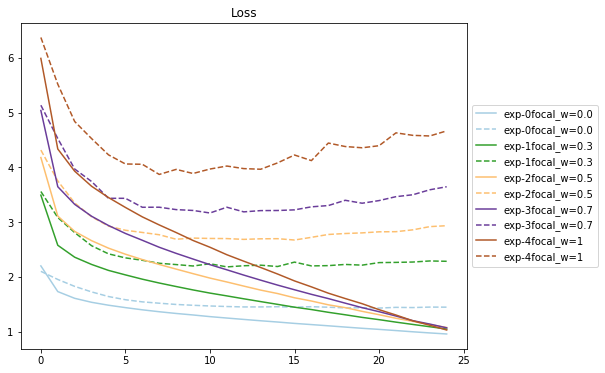

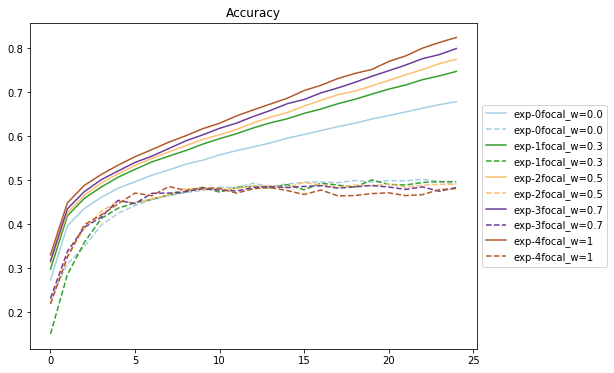

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('Paired') #gist_rainbow
#https://www.osgeo.cn/matplotlib/tutorials/colors/colormaps.html
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# WITH DIFFERENT GAMMA

In [24]:
import itertools
results = {}
gamma_list = [0., 0.5, 1, 2, 5]

for i, gamma in enumerate(gamma_list):
    print("Numbers of exp: %i, gamma: %.2f" % (i, gamma))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(gamma=gamma,focal_ratio=1), metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))+'gamma='+str(gamma)
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, gamma: 0.00
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_24 (Batc

50000/50000 [==============================] - 2s 40us/step - loss: 3.7306 - accuracy: 0.6246 - val_loss: 5.0561 - val_accuracy: 0.4992
Epoch 11/25
50000/50000 [==============================] - 2s 42us/step - loss: 3.5736 - accuracy: 0.6430 - val_loss: 5.1545 - val_accuracy: 0.4888
Epoch 12/25
50000/50000 [==============================] - 2s 38us/step - loss: 3.4231 - accuracy: 0.6548 - val_loss: 5.2084 - val_accuracy: 0.4944
Epoch 13/25
50000/50000 [==============================] - 2s 40us/step - loss: 3.2715 - accuracy: 0.6708 - val_loss: 5.3704 - val_accuracy: 0.4882
Epoch 14/25
50000/50000 [==============================] - 2s 40us/step - loss: 3.1090 - accuracy: 0.6884 - val_loss: 5.3454 - val_accuracy: 0.4904
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.9470 - accuracy: 0.7043 - val_loss: 5.3752 - val_accuracy: 0.4837
Epoch 16/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.8087 - accuracy: 0.7175 - val_loss: 5.5804

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 65us/step - loss: 5.9936 - accuracy: 0.3325 - val_loss: 6.8439 - val_accuracy: 0.1880
Epoch 2/25
50000/50000 [==============================] - 2s 39us/step - loss: 4.3624 - accuracy: 0.4458 - val_loss: 5.4016 - val_accuracy: 0.3341
Epoch 3/25
50000/50000 [==============================] - 2s 39us/step - loss: 3.9374 - accuracy: 0.4864 - val_loss: 4.8394 - val_accuracy: 0.4005
Epoch 4/25
50000/50000 [==============================] - 2s 38us/step - loss: 3.6739 - accuracy: 0.5143 - val_loss: 4.4653 - val_accuracy: 0.4313
Epoch 5/25
50000/50000 [==============================] - 2s 38us/step - loss: 3.4626 - accuracy: 0.5321 - val_loss: 4.1954 - val_accuracy: 0.4506
Epoch 6/25
50000/50000 [==============================] - 2s 39us/step - loss: 3.2866 - accuracy: 0.5515 - val_loss: 4.0041 - val_accuracy: 0.4690
Epoch 7/25
50000/50000 [==============================] - 2s 40us/st

50000/50000 [==============================] - 2s 40us/step - loss: 0.9420 - accuracy: 0.6804 - val_loss: 2.7802 - val_accuracy: 0.4788
Epoch 21/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.8817 - accuracy: 0.6889 - val_loss: 2.7109 - val_accuracy: 0.4784
Epoch 22/25
50000/50000 [==============================] - 2s 41us/step - loss: 0.8229 - accuracy: 0.7013 - val_loss: 2.8347 - val_accuracy: 0.4728
Epoch 23/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.7665 - accuracy: 0.7116 - val_loss: 2.8438 - val_accuracy: 0.4720
Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.7093 - accuracy: 0.7220 - val_loss: 2.8584 - val_accuracy: 0.4751
Epoch 25/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.6611 - accuracy: 0.7324 - val_loss: 2.8494 - val_accuracy: 0.4747


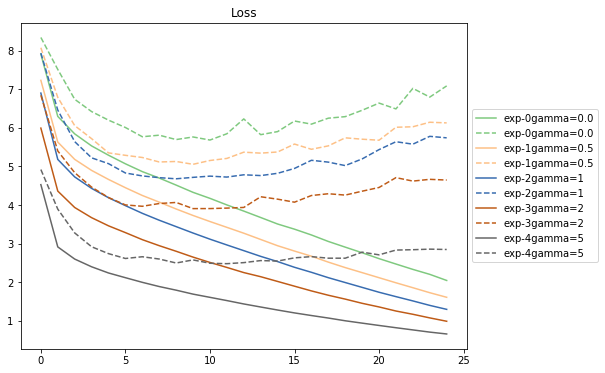

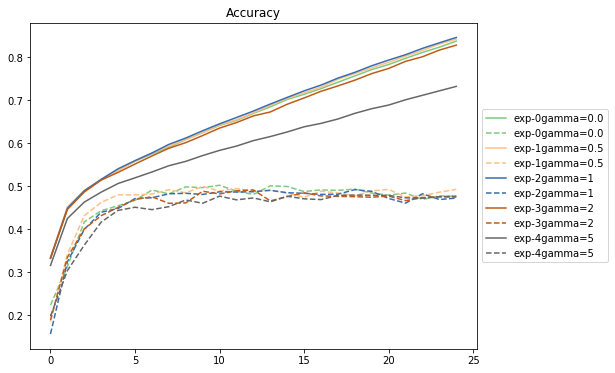

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('Accent') #gist_rainbow
#https://www.osgeo.cn/matplotlib/tutorials/colors/colormaps.html
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()